In [1]:
import ipyparallel as ipp
c = ipp.Client()
print(c.ids)

[0, 1, 2, 3]


In [2]:
%%px
import numpy as np

from mpi4py import MPI
from pylbm import lbm
from typing import Tuple


In [ ]:
%%px
def save_mpiio(comm, fn, g_kl):
    """
    Write a global two-dimensional array to a single file in the npy format
    using MPI I/O: https://docs.scipy.org/doc/numpy/neps/npy-format.html

    Arrays written with this function can be read with numpy.load.

    Parameters
    ----------
    comm
        MPI communicator.
    fn : str
        File name.
    g_kl : array_like
        Portion of the array on this MPI processes. This needs to be a
        two-dimensional array.
    """
    from numpy.lib.format import dtype_to_descr, magic
    magic_str = magic(1, 0)

    local_nx, local_ny = g_kl.shape
    nx = np.empty_like(local_nx)
    ny = np.empty_like(local_ny)

    commx = comm.Sub((True, False))
    commy = comm.Sub((False, True))
    commx.Allreduce(np.asarray(local_nx), nx)
    commy.Allreduce(np.asarray(local_ny), ny)

    arr_dict_str = str({ 'descr': dtype_to_descr(g_kl.dtype),
                         'fortran_order': False,
                         'shape': (np.asscalar(nx), np.asscalar(ny)) })
    while (len(arr_dict_str) + len(magic_str) + 2) % 16 != 15:
        arr_dict_str += ' '
    arr_dict_str += '\n'
    header_len = len(arr_dict_str) + len(magic_str) + 2

    offsetx = np.zeros_like(local_nx)
    commx.Exscan(np.asarray(ny*local_nx), offsetx)
    offsety = np.zeros_like(local_ny)
    commy.Exscan(np.asarray(local_ny), offsety)

    print(fn)
    file = MPI.File.Open(comm, fn, MPI.MODE_CREATE | MPI.MODE_WRONLY)
    if comm.Get_rank() == 0:
        file.Write(magic_str)
        file.Write(np.int16(len(arr_dict_str)))
        file.Write(arr_dict_str.encode('latin-1'))
    mpitype = MPI._typedict[g_kl.dtype.char]
    filetype = mpitype.Create_vector(g_kl.shape[0], g_kl.shape[1], ny)
    filetype.Commit()
    file.Set_view(header_len + (offsety+offsetx)*mpitype.Get_size(),
                  filetype=filetype)
    file.Write_all(g_kl.copy())
    filetype.Free()
    file.Close()


In [3]:
%%px
comm = MPI.COMM_WORLD
print('Rank {} of {} is alive.'.format(comm.Get_rank(), comm.Get_size()))

[stdout:1] Rank 1 of 4 is alive.


[stdout:2] Rank 2 of 4 is alive.


[stdout:3] Rank 3 of 4 is alive.


[stdout:0] Rank 0 of 4 is alive.


In [89]:
%%px
org_x_dim =30
org_y_dim = 30
sync_rows = 2
sync_cols =2
epochs = 3
omega = 1.7
top_vel = .1

In [90]:
%%px
cartcomm = comm.Create_cart(dims=[2,2], periods=(False, False))

In [153]:
%%px
def sync_shifts(cartcomm: MPI.Cartcomm):
    sR, dR = cartcomm.Shift(1, -1)
    sL, dL = cartcomm.Shift(0, 1)
    sU, dU = cartcomm.Shift(1, -1)
    sD, dD = cartcomm.Shift(0, 1)
    return (sL,dL, sR,dR, sU,dU, sD, dD)

In [154]:
%%px
def sync_f(cartcomm: MPI.Cartcomm, shifts: Tuple, f_cxy: np.array):
    sL,dL, sR,dR, sU,dU, sD, dD = shifts

    # copy left to right
    recvbuf = f_cxy[:, :, -1].copy()
    cartcomm.Sendrecv(f_cxy[:, :, 1].copy(), dest=dL, recvbuf=recvbuf, source=sL)
    f_cxy[:, :, -1] = recvbuf

    # copy right to left
    recvbuf = f_cxy[:, :, 0].copy()
    cartcomm.Sendrecv(f_cxy[:, :, -2].copy(), dest=dR, recvbuf=recvbuf, source=sR)
    f_cxy[:, :, 0] = recvbuf
    
    # copy down to up
    recvbuf = f_cxy[:, -1, :].copy()
    cartcomm.Sendrecv(f_cxy[:, 1, :].copy(), dest=dU, recvbuf=recvbuf, source=sU)
    f_cxy[:, -1, :] = recvbuf
    
    # copy up to down
    recvbuf = f_cxy[:, 0, :].copy()
    cartcomm.Sendrecv(f_cxy[:, -2, :].copy(), dest=dD, recvbuf=recvbuf, source=sD)
    f_cxy[:, 0, :] = recvbuf

    return f_cxy

In [155]:
%%px
x_dim = org_x_dim // sync_rows
y_dim = org_y_dim // sync_cols
# x_dim = org_x_dim
# y_dim = org_y_dim
r_xy = lbm.density_init(x_dim=x_dim, y_dim=y_dim, r_mean=1.0, eps=0.0)
u_axy = lbm.local_avg_velocity_init(x_dim=x_dim, y_dim=y_dim, u_mean=0.0, eps=0.0)
f_cxy = lbm.f_eq(u_axy=u_axy, r_xy=r_xy)
shifts = sync_shifts(cartcomm)

for t in range(epochs):
    f_cxy = sync_f(cartcomm, shifts, f_cxy)
    f_cxy = lbm.stream(f_cxy=f_cxy)
    rank = cartcomm.Get_rank()
    coords = cartcomm.Get_coords(rank)
    if coords == [1,1]:
        f_cxy = lbm.apply_sliding_top_wall_simple(f_cxy=f_cxy, velocity=top_vel)
    # if coords == [0,0]:
    #     f_cxy = lbm.apply_bottom_wall(f_cxy=f_cxy)
    # if coords == [0,1]:
    #     f_cxy = lbm.left_wall(f_cxy=f_cxy)
    # if coords == [1,0]:
    #     f_cxy = lbm.right_wall(f_cxy=f_cxy)

    f_cxy, u_axy = lbm.collision(f_cxy=f_cxy, omega=omega)

In [156]:
%%px
dir = "/home/joe/repos/pylbm/milestones/m7/"
save_mpiio(cartcomm, dir+'./ux.npy', u_axy[0, :, :])
save_mpiio(cartcomm, dir+'./uy.npy', u_axy[1, :, :])

[stdout:3] /home/joe/repos/pylbm/milestones/m7/./ux.npy
/home/joe/repos/pylbm/milestones/m7/./uy.npy


[stdout:2] /home/joe/repos/pylbm/milestones/m7/./ux.npy
/home/joe/repos/pylbm/milestones/m7/./uy.npy


[stdout:1] /home/joe/repos/pylbm/milestones/m7/./ux.npy
/home/joe/repos/pylbm/milestones/m7/./uy.npy


[stdout:0] /home/joe/repos/pylbm/milestones/m7/./ux.npy
/home/joe/repos/pylbm/milestones/m7/./uy.npy


[stderr:2] /tmp/ipykernel_260/3418377507.py:32: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'shape': (np.asscalar(nx), np.asscalar(ny)) })


[stderr:3] /tmp/ipykernel_261/3418377507.py:32: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'shape': (np.asscalar(nx), np.asscalar(ny)) })


[stderr:1] /tmp/ipykernel_259/3418377507.py:32: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'shape': (np.asscalar(nx), np.asscalar(ny)) })


[stderr:0] /tmp/ipykernel_258/3418377507.py:32: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'shape': (np.asscalar(nx), np.asscalar(ny)) })


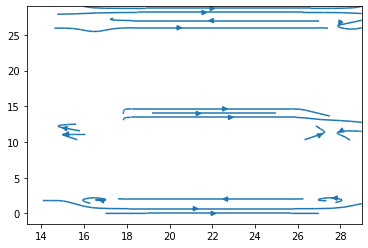

In [157]:
import matplotlib.pyplot as plt
import numpy as np
ux_kl = np.load('./ux.npy')
uy_kl = np.load('./uy.npy')

nx, ny = ux_kl.shape

plt.figure()
x_k = np.arange(nx)
y_l = np.arange(ny)
plt.streamplot(x_k, y_l, ux_kl.T, uy_kl.T)
plt.show()